# Train RNN to Solve Parametric Working Memory

In [1]:
import brainpy as bp
import brainpy.math as bm
bp.math.set_platform('cpu')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
# We will import the task from the neurogym library.
# Please install neurogym:
# 
# https://github.com/neurogym/neurogym

import neurogym as ngym

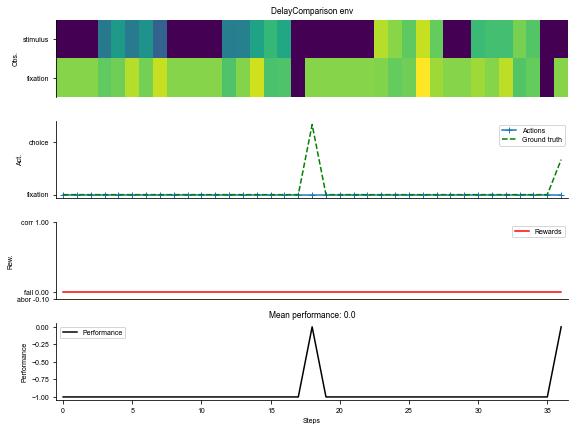

In [4]:
# Environment
task = 'DelayComparison-v0'
timing = {'delay': ('choice', [200, 400, 800, 1600, 3200]),
          'response': ('constant', 500)}
kwargs = {'dt': 100, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task,
                       env_kwargs=kwargs,
                       batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2, def_act=0, fig_kwargs={'figsize': (8, 6)})
plt.show()

In [5]:
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
batch_size = dataset.batch_size

In [6]:
class RNN(bp.dyn.DynamicalSystem):
  def __init__(self, num_input, num_hidden, num_output, num_batch,
               w_ir=bp.init.KaimingNormal(scale=1.),
               w_rr=bp.init.KaimingNormal(scale=1.),
               w_ro=bp.init.KaimingNormal(scale=1.),
               dt=None, seed=None):
    super(RNN, self).__init__()

    # parameters
    self.tau = 100
    self.num_batch = num_batch
    self.num_input = num_input
    self.num_hidden = num_hidden
    self.num_output = num_output
    if dt is None:
      self.alpha = 1
    else:
      self.alpha = dt / self.tau
    self.rng = bm.random.RandomState(seed=seed)

    # input weight
    self.w_ir = bm.TrainVar(bp.init.parameter(w_ir, size=(num_input, num_hidden)))

    # recurrent weight
    bound = 1 / num_hidden ** 0.5
    self.w_rr = bm.TrainVar(bp.init.parameter(w_rr, size=(num_hidden, num_hidden)))
    self.b_rr = bm.TrainVar(self.rng.uniform(-bound, bound, num_hidden))

    # readout weight
    self.w_ro = bm.TrainVar(bp.init.parameter(w_ro, size=(num_hidden, num_output)))
    self.b_ro = bm.TrainVar(self.rng.uniform(-bound, bound, num_output))

    # variables
    self.h = bm.Variable(bm.zeros((num_batch, num_hidden)))
    self.o = bm.Variable(bm.zeros((num_batch, num_output)))

  def cell(self, x, h):
    ins = x @ self.w_ir + h @ self.w_rr + self.b_rr
    state = h * (1 - self.alpha) + ins * self.alpha
    return bm.relu(state)

  def readout(self, h):
    return h @ self.w_ro + self.b_ro

  def update(self, x):
    self.h.value = self.cell(x, self.h.value)
    self.o.value = self.readout(self.h.value)
    return self.h.value, self.o.value

  def predict(self, xs):
    self.h[:] = 0.
    return bm.for_loop(self.update, xs)

  def loss(self, xs, ys):
    hs, os = self.predict(xs)
    os = os.reshape((-1, os.shape[-1]))
    loss = bp.losses.cross_entropy_loss(os, ys.flatten())
    return loss, os

In [7]:
# Instantiate the network and print information
hidden_size = 64
net = RNN(num_input=input_size,
          num_hidden=hidden_size,
          num_output=output_size,
          num_batch=batch_size,
          dt=env.dt)

In [8]:
predict = bm.jit(net.predict)

In [9]:
# Adam optimizer
opt = bp.optim.Adam(lr=0.001, train_vars=net.train_vars().unique())

In [10]:
# gradient function
grad = bm.grad(net.loss,
               grad_vars=net.train_vars().unique(),
               return_value=True,
               has_aux=True)

In [11]:
@bm.jit
@bm.to_object(child_objs=(grad, opt))
def train(xs, ys):
  grads, loss, os = grad(xs, ys)
  opt.update(grads)
  return loss, os

In [12]:
running_acc = 0
running_loss = 0
for i in range(2000):
  inputs, labels_np = dataset()
  inputs = bm.asarray(inputs)
  labels = bm.asarray(labels_np)
  loss, outputs = train(inputs, labels)
  running_loss += loss
  # Compute performance
  output_np = np.argmax(bm.as_numpy(outputs), axis=-1).flatten()
  labels_np = labels_np.flatten()
  ind = labels_np > 0  # Only analyze time points when target is not fixation
  running_acc += np.mean(labels_np[ind] == output_np[ind])
  if i % 100 == 99:
    running_loss /= 100
    running_acc /= 100
    print('Step {}, Loss {:0.4f}, Acc {:0.3f}'.format(i + 1, running_loss, running_acc))
    running_loss = 0
    running_acc = 0

Step 100, Loss 0.2515, Acc 0.086
Step 200, Loss 0.0319, Acc 0.734
Step 300, Loss 0.0178, Acc 0.851
Step 400, Loss 0.0137, Acc 0.884
Step 500, Loss 0.0119, Acc 0.896
Step 600, Loss 0.0107, Acc 0.899
Step 700, Loss 0.0095, Acc 0.914
Step 800, Loss 0.0094, Acc 0.904
Step 900, Loss 0.0090, Acc 0.910
Step 1000, Loss 0.0088, Acc 0.906
Step 1100, Loss 0.0077, Acc 0.918
Step 1200, Loss 0.0068, Acc 0.932
Step 1300, Loss 0.0074, Acc 0.913
Step 1400, Loss 0.0068, Acc 0.924
Step 1500, Loss 0.0064, Acc 0.929
Step 1600, Loss 0.0069, Acc 0.917
Step 1700, Loss 0.0066, Acc 0.921
Step 1800, Loss 0.0062, Acc 0.930
Step 1900, Loss 0.0061, Acc 0.928
Step 2000, Loss 0.0064, Acc 0.922


In [15]:
def run(num_trial=1):
  env.reset(no_step=True)
  perf = 0
  activity_dict = {}
  trial_infos = {}
  for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = bm.asarray(ob[:, np.newaxis, :])
    rnn_activity, action_pred = predict(inputs)
    rnn_activity = bm.as_numpy(rnn_activity)[:, 0, :]
    activity_dict[i] = rnn_activity
    trial_infos[i] = env.trial

  # Concatenate activity for PCA
  activity = np.concatenate(list(activity_dict[i] for i in range(num_trial)), axis=0)
  print('Shape of the neural activity: (Time points, Neurons): ', activity.shape)

  # Print trial informations
  for i in range(5):
    if i >= num_trial: break
    print('Trial ', i, trial_infos[i])

  pca = PCA(n_components=2)
  pca.fit(activity)
  # print('Shape of the projected activity: (Time points, PCs): ', activity_pc.shape)

  fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 3))
  for i in range(num_trial):
    activity_pc = pca.transform(activity_dict[i])
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 0 else 'blue'
    _ = ax1.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)
    if i < 3:
      _ = ax2.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)
  ax1.set_xlabel('PC 1')
  ax1.set_ylabel('PC 2')
  plt.show()

Shape of the neural activity: (Time points, Neurons):  (48, 64)
Trial  0 {'ground_truth': 1, 'vpair': (18, 10), 'v1': 18, 'v2': 10}


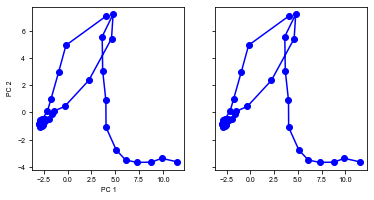

In [16]:
run(num_trial=1)

Shape of the neural activity: (Time points, Neurons):  (534, 64)
Trial  0 {'ground_truth': 1, 'vpair': (30, 22), 'v1': 30, 'v2': 22}
Trial  1 {'ground_truth': 1, 'vpair': (18, 10), 'v1': 18, 'v2': 10}
Trial  2 {'ground_truth': 1, 'vpair': (22, 14), 'v1': 22, 'v2': 14}
Trial  3 {'ground_truth': 1, 'vpair': (34, 26), 'v1': 34, 'v2': 26}
Trial  4 {'ground_truth': 1, 'vpair': (26, 18), 'v1': 26, 'v2': 18}


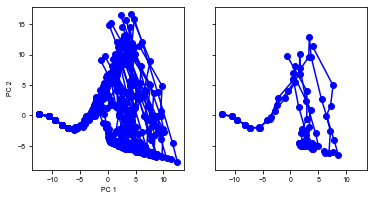

In [17]:
run(num_trial=20)

Shape of the neural activity: (Time points, Neurons):  (2756, 64)
Trial  0 {'ground_truth': 2, 'vpair': (34, 26), 'v1': 26, 'v2': 34}
Trial  1 {'ground_truth': 1, 'vpair': (26, 18), 'v1': 26, 'v2': 18}
Trial  2 {'ground_truth': 2, 'vpair': (22, 14), 'v1': 14, 'v2': 22}
Trial  3 {'ground_truth': 2, 'vpair': (30, 22), 'v1': 22, 'v2': 30}
Trial  4 {'ground_truth': 1, 'vpair': (34, 26), 'v1': 34, 'v2': 26}


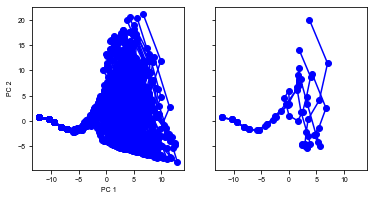

In [18]:
run(num_trial=100)